In [ ]:
# Initialization code that runs before all other cells
import os
from collections import Counter

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)


import marimo as mo

# Model

In [ ]:
def preprocessing(image_path, threshold_value=None):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)  # to reduce noise

    # threshold the image to convert to binary
    if threshold_value is None:
        threshold_value = np.max(blur) / 2 + np.min(blur) / 2
    _, thresholded_image = cv2.threshold(
        blur, threshold_value, 255, cv2.THRESH_BINARY_INV
    )

    return thresholded_image

In [ ]:
def find_contour(thresholded_image):
    contours, _ = cv2.findContours(
        thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        return None

    # assume the largest contour is our shape
    contour = max(contours, key=cv2.contourArea)

    # filter out tiny contours that are likely noise
    if cv2.contourArea(contour) < 100:
        return None

    return contour

In [ ]:
def extract_features_from_contour(contour):
    # Hu moments
    M = cv2.moments(contour)

    if M["m00"] == 0:
        return None  # avoid divide-by-zero

    hu_moments = cv2.HuMoments(M).flatten()
    # to make them more stable and comparable
    hu_moments = (
        -1 * np.copysign(1.0, hu_moments) * np.log10(abs(hu_moments) + 1e-7)
    )

    # corners
    perimeter = cv2.arcLength(contour, True)
    epsilon = (
        0.03 * perimeter
    )  # 3% of perimeter is a good starting point for approximation
    approx = cv2.approxPolyDP(contour, epsilon, True)
    num_corners = len(approx)

    # solidity
    area = M["m00"]  # cv2.contourArea(contour)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0

    # aspect ratio
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h if h > 0 else 0

    # circularity
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0

    # final feature vector
    features = np.append(
        [num_corners, solidity, aspect_ratio, circularity], hu_moments
    )

    return features

In [ ]:
def extract_features(image_path):
    thresholded_image = preprocessing(image_path)
    contour = find_contour(thresholded_image)
    if contour is None:
        return None
    features = extract_features_from_contour(contour)

    return features

In [ ]:
@mo.cache
def load_data(dataset_path, labels):
    all_features = []
    all_labels = []

    feature_names = [
        "num_corners",
        "solidity",
        "aspect_ratio",
        "circularity",
        "hu1",
        "hu2",
        "hu3",
        "hu4",
        "hu5",
        "hu6",
        "hu7",
    ]

    for label in mo.status.progress_bar(
        labels, title=f"Loading dataset of {len(labels)} labels"
    ):
        label_path = os.path.join(dataset_path, label)
        if not os.path.isdir(label_path):
            print(f"Warning: Label directory not found: {label_path}")
            continue

        for filename in mo.status.progress_bar(
            os.listdir(label_path),
            title=f"Extracting features for label '{label}'",
            remove_on_exit=True,
        ):
            if filename.endswith(".png"):
                image_path = os.path.join(label_path, filename)
                features = extract_features(image_path)

                if features is not None and len(features) == len(
                    feature_names
                ):
                    all_features.append(features)
                    all_labels.append(label)

    df = pd.DataFrame(all_features, columns=feature_names)
    df["label"] = all_labels

    return df

# Evaluation

In [ ]:
DATASET_DIR = mo.notebook_dir() / "dataset_classic"
LABELS = [
    "parallelogram",
    "triangle",
    "pentagon",
    "rectangle",
    "square",
    "circle",
    "trapezoid",
    "oval",
    "semicircle",
    "rhombus",
]

data = load_data(DATASET_DIR, LABELS)

mo.stop(data.empty, mo.md("**Error**: No data was loaded. Exiting!"))
mo.output.append(
    mo.md(f"Successfully loaded and processed **{len(data)}** samples.")
)

Successfully loaded and processed 120000 samples.

In [ ]:
X = data.drop("label", axis=1)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,  # to ensure all classes are represented in train/test splits
)

In [ ]:
X

<marimo-table data-initial-value='[]' data-label='null' data-data='"[{\"num_corners\":4.0,\"solidity\":0.9932595701,\"aspect_ratio\":2.3333333333,\"circularity\":0.6445102649,\"hu1\":0.6684642629,\"hu2\":1.7383069147,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":-7.0,\"hu7\":-7.0},{\"num_corners\":4.0,\"solidity\":0.9910744936,\"aspect_ratio\":2.4358974359,\"circularity\":0.6208107108,\"hu1\":0.6586770524,\"hu2\":1.6905102784,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":7.0,\"hu7\":7.0},{\"num_corners\":4.0,\"solidity\":0.9940087146,\"aspect_ratio\":2.2533333333,\"circularity\":0.6553384859,\"hu1\":0.6750342879,\"hu2\":1.7723044725,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":-7.0,\"hu7\":-7.0},{\"num_corners\":4.0,\"solidity\":0.9915576192,\"aspect_ratio\":2.4285714286,\"circularity\":0.6295648429,\"hu1\":0.6617286055,\"hu2\":1.7049798696,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":-7.0,\"hu7\":7.0},{\"num_corners\":4.0,\"solidity\":0.9943679599,\"aspect_ratio\":2.4146341463,\"circularity\":0.6260445571,\"hu1\":0.6617173398,\"hu2\":1.7046628763,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":-7.0,\"hu7\":-7.0},{\"num_corners\":4.0,\"solidity\":0.9934831461,\"aspect_ratio\":2.3134328358,\"circularity\":0.6475703142,\"hu1\":0.6696947566,\"hu2\":1.7445703709,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":-7.0,\"hu7\":-7.0},{\"num_corners\":4.0,\"solidity\":0.9942971486,\"aspect_ratio\":2.2957746479,\"circularity\":0.6503000281,\"hu1\":0.6707155965,\"hu2\":1.7498084775,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":-7.0,\"hu7\":-7.0},{\"num_corners\":4.0,\"solidity\":0.9912909836,\"aspect_ratio\":2.4222222222,\"circularity\":0.6282424695,\"hu1\":0.6636336123,\"hu2\":1.7140803124,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":-7.0,\"hu7\":-7.0},{\"num_corners\":4.0,\"solidity\":0.9936454141,\"aspect_ratio\":2.3043478261,\"circularity\":0.648973028,\"hu1\":0.6701930233,\"hu2\":1.7471234772,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":7.0,\"hu6\":7.0,\"hu7\":7.0},{\"num_corners\":4.0,\"solidity\":0.9920777818,\"aspect_ratio\":2.3962264151,\"circularity\":0.6349514575,\"hu1\":0.6640546635,\"hu2\":1.716300736,\"hu3\":7.0,\"hu4\":7.0,\"hu5\":-7.0,\"hu6\":7.0,\"hu7\":-7.0}]"' data-total-rows='120000' data-total-columns='11' data-max-columns='50' data-banner-text='""' data-pagination='true' data-page-size='10' data-field-types='[["num_corners",["number","float64"]],["solidity",["number","float64"]],["aspect_ratio",["number","float64"]],["circularity",["number","float64"]],["hu1",["number","float64"]],["hu2",["number","float64"]],["hu3",["number","float64"]],["hu4",["number","float64"]],["hu5",["number","float64"]],["hu6",["number","float64"]],["hu7",["number","float64"]]]' data-show-filters='true' data-show-download='true' data-show-column-summaries='true' data-show-data-types='true' data-show-page-size-selector='true' data-show-column-explorer='true' data-show-chart-builder='true' data-row-headers='[]' data-has-stable-row-id='false' data-lazy='false' data-preload='false'>

In [ ]:
mo.output.append("Training Random Forest classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
mo.output.append("Training complete.")

Training Random Forest classifier... Training complete.

In [ ]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
mo.output.append(mo.md(f"Model Accuracy: **{acc * 100:.2f}%**"))

Model Accuracy: 99.09%

In [ ]:
mo.output.append(mo.md("**Classification Report:**"))
print(classification_report(y_test, y_pred, labels=LABELS))

               precision    recall  f1-score   support

parallelogram       1.00      1.00      1.00      2400
     triangle       1.00      1.00      1.00      2400
     pentagon       1.00      1.00      1.00      2400
    rectangle       1.00      1.00      1.00      2400
       square       0.97      0.94      0.95      2400
       circle       1.00      1.00      1.00      2400
    trapezoid       1.00      1.00      1.00      2400
         oval       1.00      1.00      1.00      2400
   semicircle       1.00      1.00      1.00      2400
      rhombus       0.94      0.97      0.96      2400

     accuracy                           0.99     24000
    macro avg       0.99      0.99      0.99     24000
 weighted avg       0.99      0.99      0.99     24000



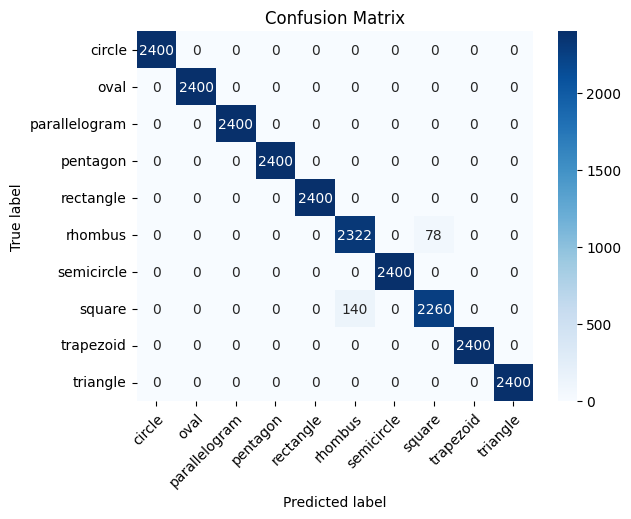

In [ ]:
C = confusion_matrix(y_test, y_pred, labels=model.classes_)

ax = sns.heatmap(
    C, annot=True, fmt=".0f", cmap=sns.color_palette("Blues", as_cmap=True)
)
ax.set_xticklabels(
    model.classes_, rotation=45, rotation_mode="anchor", ha="right"
)
ax.set_yticklabels(model.classes_, rotation=0)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix")

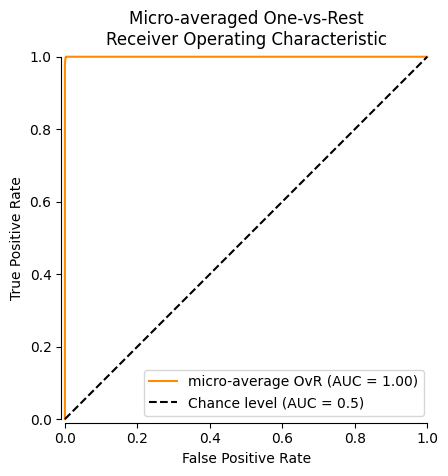

In [ ]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_score = model.predict_proba(X_test)

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    curve_kwargs=dict(color="darkorange"),
    plot_chance_level=True,
    despine=True,
)
display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

# Multi object image

In [ ]:
def find_all_contours(thresholded_image):
    contours, _ = cv2.findContours(
        thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    filtered_contours = [
        contour for contour in contours if cv2.contourArea(contour) >= 100
    ]

    return filtered_contours

In [ ]:
def extract_features_from_all_shapes(image_path, threshold_value=None):
    feature_names = [
        "num_corners",
        "solidity",
        "aspect_ratio",
        "circularity",
        "hu1",
        "hu2",
        "hu3",
        "hu4",
        "hu5",
        "hu6",
        "hu7",
    ]

    thresholded_image = preprocessing(image_path, threshold_value)
    contours = find_all_contours(thresholded_image)
    mo.output.append(f"Found {len(contours)} contours in the image.")

    if len(contours) == 0:
        return None

    all_contours_features = []
    for contour in contours:
        all_contours_features.append(extract_features_from_contour(contour))

    df = pd.DataFrame(all_contours_features, columns=feature_names)

    return df

In [ ]:
multi_shape_image = mo.notebook_dir() / "shapes_used.png"
mo.image(multi_shape_image)

In [ ]:
all_shapes_features = extract_features_from_all_shapes(
    multi_shape_image, threshold_value=250
)
predicted_shapes = model.predict(all_shapes_features)
Counter(predicted_shapes)

Counter({'circle': 3, 'triangle': 3, 'pentagon': 2, 'rectangle': 1, 'oval': 1, 'trapezoid': 1})